**Important Note:** K-Means is sensitive to feature scales, so feature scaling (e.g., using StandardScaler) is almost always a necessary preprocessing step.

#### Example 1: K-Means Clustering on Synthetic make_blobs Data

- This example uses make_blobs from sklearn.datasets to generate well-separated clusters, making it easy to visualize the K-Means algorithm in action and the Elbow method for choosing K.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- 1. Generate Synthetic Data with Clear Clusters ---
# We'll create data with a known number of clusters to see if K-Means can find them.
n_samples = 300
n_features = 2
n_clusters_true = 4 # True number of clusters we are generating
random_state = 42

X_blobs, y_blobs_true = make_blobs(n_samples=n_samples,
                                   n_features=n_features,
                                   centers=n_clusters_true,
                                   cluster_std=0.8, # Standard deviation of the clusters
                                   random_state=random_state)

X_blobs_df = pd.DataFrame(X_blobs, columns=['Feature_1', 'Feature_2'])
print("Synthetic 'make_blobs' Dataset Generated.")
print(f"Features shape: {X_blobs_df.shape}")


Synthetic 'make_blobs' Dataset Generated.
Features shape: (300, 2)


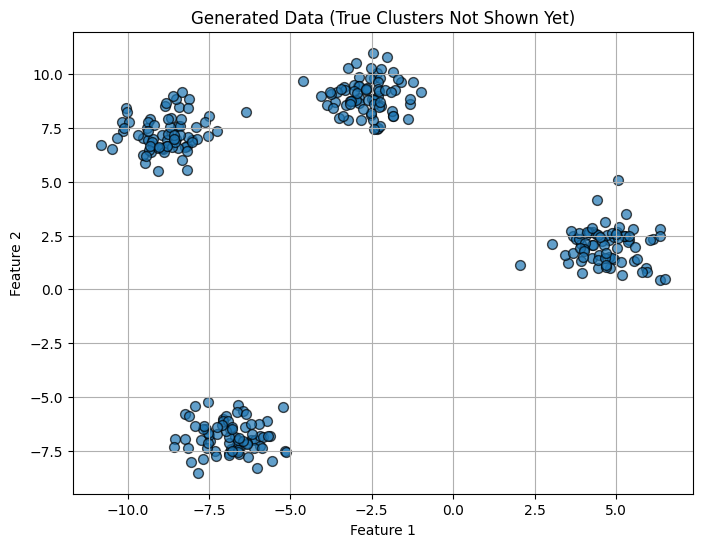

In [3]:
# Visualize the generated data (without cluster labels initially)
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs_df['Feature_1'], X_blobs_df['Feature_2'], s=50, alpha=0.7, edgecolors='k')
plt.title("Generated Data (True Clusters Not Shown Yet)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [4]:
# --- 2. Feature Scaling ---
# Although make_blobs might generate features with similar scales,
# scaling is a good habit for K-Means.
scaler_blobs = StandardScaler()
X_blobs_scaled = scaler_blobs.fit_transform(X_blobs_df)
print("\nData Scaled.")


Data Scaled.



--- Determining Optimal K using the Elbow Method ---


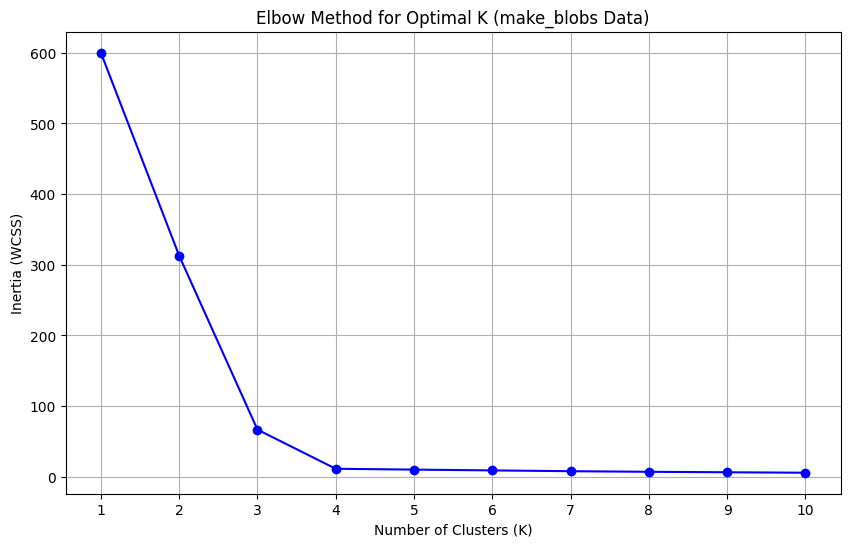

In [5]:
# --- 3. Determine Optimal K using the Elbow Method ---
print("\n--- Determining Optimal K using the Elbow Method ---")
inertia_values = []
k_range = range(1, 11) # Test K from 1 to 10

for k_test in k_range:
    kmeans_test = KMeans(n_clusters=k_test,
                         init='k-means++', # Smart initialization
                         n_init=10,        # Run K-Means 10 times with different centroid seeds
                         max_iter=300,     # Max iterations for a single run
                         random_state=random_state)
    kmeans_test.fit(X_blobs_scaled)
    inertia_values.append(kmeans_test.inertia_) # Inertia is WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K (make_blobs Data)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [6]:
# From the plot, we expect to see an "elbow" around K=4 for this data.
# Let's assume K=4 is chosen based on the elbow.
optimal_k_blobs = 4
print(f"Based on the Elbow Method, optimal K chosen: {optimal_k_blobs}")

Based on the Elbow Method, optimal K chosen: 4


In [7]:
# --- 4. Apply K-Means with the Chosen K ---
print(f"\n--- Applying K-Means with K={optimal_k_blobs} ---")
kmeans_final_blobs = KMeans(n_clusters=optimal_k_blobs,
                            init='k-means++',
                            n_init=10,
                            max_iter=300,
                            random_state=random_state)
cluster_labels_blobs = kmeans_final_blobs.fit_predict(X_blobs_scaled)
centroids_blobs = kmeans_final_blobs.cluster_centers_

# Add cluster labels to the original (unscaled) DataFrame for easier interpretation if needed
X_blobs_df['KMeans_Cluster'] = cluster_labels_blobs

print(f"Inertia for K={optimal_k_blobs}: {kmeans_final_blobs.inertia_:.2f}")
# print("Centroid locations (scaled space):\n", centroids_blobs)


--- Applying K-Means with K=4 ---
Inertia for K=4: 11.32


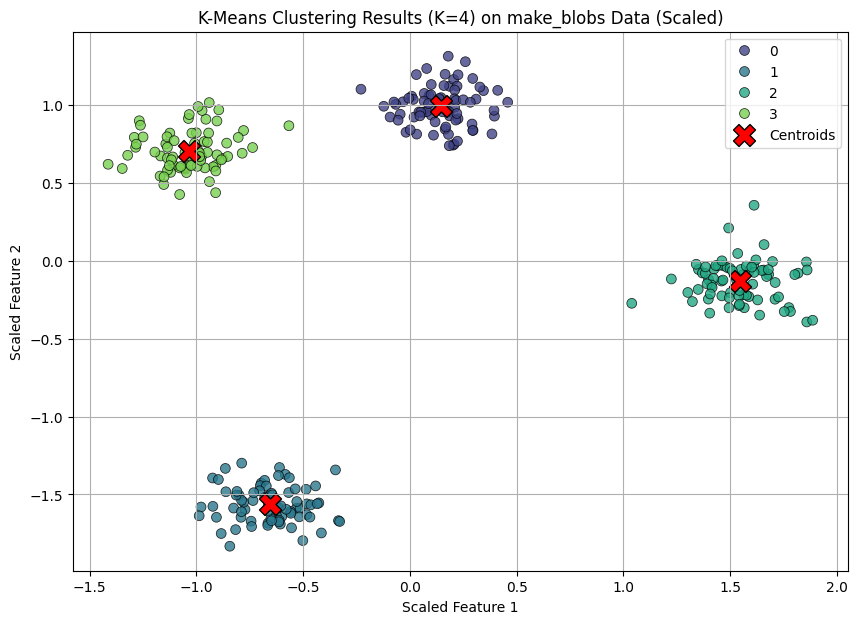

In [8]:
# --- 5. Visualize the Clustering Results ---
plt.figure(figsize=(10, 7))
# Plot data points colored by their assigned cluster
# Use X_blobs_scaled for plotting if centroids are in scaled space,
# or X_blobs_df features if you want to see original scales (but centroids need inverse_transform then)
# For simplicity, plot scaled data with scaled centroids.
sns.scatterplot(x=X_blobs_scaled[:, 0], y=X_blobs_scaled[:, 1], hue=cluster_labels_blobs,
                palette=sns.color_palette("viridis", n_colors=optimal_k_blobs),
                s=50, alpha=0.8, legend='full', edgecolor='k')

# Plot the centroids
plt.scatter(centroids_blobs[:, 0], centroids_blobs[:, 1],
            s=250, marker='X', c='red', edgecolor='black', label='Centroids')

plt.title(f"K-Means Clustering Results (K={optimal_k_blobs}) on make_blobs Data (Scaled)")
plt.xlabel("Scaled Feature 1")
plt.ylabel("Scaled Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Compare with true labels (if available, for evaluation in synthetic cases)
# from sklearn.metrics import adjusted_rand_score
# ari_blobs = adjusted_rand_score(y_blobs_true, cluster_labels_blobs)
# print(f"\nAdjusted Rand Index (vs true labels): {ari_blobs:.4f}")


**Discussion for make_blobs Example:***

- The make_blobs function is perfect for creating data where distinct clusters exist.
- The Elbow Method plot should clearly show a bend (elbow) at K=4 (since we generated 4 clusters), indicating that this is a good choice for the number of clusters.
- The final scatter plot will visualize the data points colored by their assigned K-Means cluster, with the calculated centroids marked. You should see that K-Means successfully identifies the underlying groups.

---
#### Example 2: K-Means Clustering on Wholesale Customers Data

- This example uses a real-world dataset, the "Wholesale customers data," which contains information on clients of a wholesale distributor.
- We'll try to segment customers based on their annual spending on diverse product categories.
- Dataset Source (UCI Machine Learning Repository): A common version can be found here: https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv
- For this example, We'll use ´´Wholesale_customers_data.csv´´ from our working directory.

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # For visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# --- 1. Load Wholesale Customers Dataset ---
try:
    wholesale_df = pd.read_csv('Wholesale customers data.csv')
except FileNotFoundError:
    print("Error: 'Wholesale customers data.csv' not found. Please download it and place it in your working directory.")
    # As a fallback for execution, create a dummy DataFrame if file not found
    data_dummy = {
        'Channel': np.random.randint(1, 3, size=100),
        'Region': np.random.randint(1, 4, size=100),
        'Fresh': np.random.randint(1000, 50000, size=100),
        'Milk': np.random.randint(500, 30000, size=100),
        'Grocery': np.random.randint(1000, 40000, size=100),
        'Frozen': np.random.randint(100, 20000, size=100),
        'Detergents_Paper': np.random.randint(10, 15000, size=100),
        'Delicassen': np.random.randint(10, 10000, size=100)
    }
    wholesale_df = pd.DataFrame(data_dummy)
    print("Using dummy data as 'Wholesale customers data.csv' was not found.")


print("Wholesale Customers Dataset Loaded.")
print("Original DataFrame head:\n", wholesale_df.head())
print(f"\nDataset shape: {wholesale_df.shape}")
print("\nDataset info:")
wholesale_df.info()
print("\nDescriptive statistics:\n", wholesale_df.describe())


Wholesale Customers Dataset Loaded.
Original DataFrame head:
    Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

Dataset shape: (440, 8)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   

In [15]:
# Drop 'Channel' and 'Region' as they are categorical and K-Means works with numerical distances.
# Or, they could be one-hot encoded, but for simplicity here we drop them.
# We are interested in clustering based on spending habits.
data_for_clustering = wholesale_df.drop(['Channel', 'Region'], axis=1)
print("\nDropped 'Channel' and 'Region' columns for clustering.")



Dropped 'Channel' and 'Region' columns for clustering.


In [16]:
# --- 2. Feature Scaling ---
# The spending amounts vary greatly, so scaling is essential.
scaler_wholesale = StandardScaler()
X_wholesale_scaled = scaler_wholesale.fit_transform(data_for_clustering)
X_wholesale_scaled_df = pd.DataFrame(X_wholesale_scaled, columns=data_for_clustering.columns)
print("\nData Scaled using StandardScaler.")
print("Scaled data head:\n", X_wholesale_scaled_df.head())



Data Scaled using StandardScaler.
Scaled data head:
       Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  0.052933  0.523568 -0.041115 -0.589367         -0.043569   -0.066339
1 -0.391302  0.544458  0.170318 -0.270136          0.086407    0.089151
2 -0.447029  0.408538 -0.028157 -0.137536          0.133232    2.243293
3  0.100111 -0.624020 -0.392977  0.687144         -0.498588    0.093411
4  0.840239 -0.052396 -0.079356  0.173859         -0.231918    1.299347



--- Determining Optimal K using the Elbow Method (Wholesale Data) ---


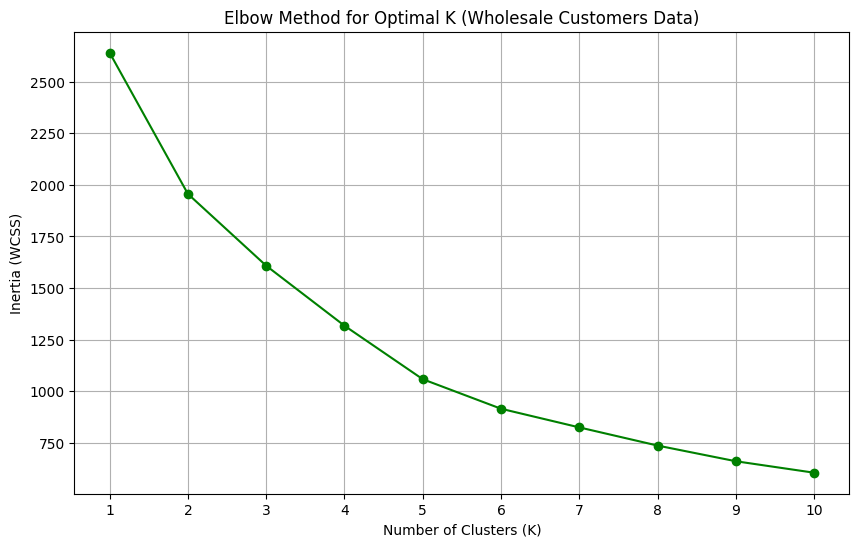

In [17]:
# --- 3. Determine Optimal K using the Elbow Method ---
print("\n--- Determining Optimal K using the Elbow Method (Wholesale Data) ---")
inertia_values_ws = []
k_range_ws = range(1, 11)

for k_test in k_range_ws:
    kmeans_test_ws = KMeans(n_clusters=k_test, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans_test_ws.fit(X_wholesale_scaled)
    inertia_values_ws.append(kmeans_test_ws.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range_ws, inertia_values_ws, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K (Wholesale Customers Data)")
plt.xticks(k_range_ws)
plt.grid(True)
plt.show()

In [18]:
# The elbow might be less obvious here. Let's assume K=3 or K=4 based on visual inspection.
# For this example, let's pick K=3.
optimal_k_ws = 3
print(f"Based on the Elbow Method (visual inspection), choosing K={optimal_k_ws}")


Based on the Elbow Method (visual inspection), choosing K=3


In [19]:
# --- 4. Apply K-Means with the Chosen K ---
print(f"\n--- Applying K-Means with K={optimal_k_ws} (Wholesale Data) ---")
kmeans_final_ws = KMeans(n_clusters=optimal_k_ws, init='k-means++', n_init=10, max_iter=300, random_state=42)
cluster_labels_ws = kmeans_final_ws.fit_predict(X_wholesale_scaled)
centroids_ws_scaled = kmeans_final_ws.cluster_centers_

# Add cluster labels back to the original (unscaled) DataFrame to analyze segments
wholesale_df['KMeans_Cluster'] = cluster_labels_ws
data_for_clustering['KMeans_Cluster'] = cluster_labels_ws # Also to the unscaled data used for clustering

print(f"Inertia for K={optimal_k_ws}: {kmeans_final_ws.inertia_:.2f}")



--- Applying K-Means with K=3 (Wholesale Data) ---
Inertia for K=3: 1608.43


In [20]:
# --- 5. Analyze Cluster Characteristics ---
# Calculate mean spending for each product category per cluster
cluster_summary = data_for_clustering.groupby('KMeans_Cluster').mean()
print("\nCluster Summary (Mean Spending per Category):")
print(cluster_summary)


Cluster Summary (Mean Spending per Category):
                       Fresh          Milk       Grocery        Frozen  \
KMeans_Cluster                                                           
0               10440.933333  19386.422222  28656.088889   2190.244444   
1               12062.913486   4115.099237   5534.966921   2940.676845   
2               34782.000000  30367.000000  16898.000000  48701.500000   

                Detergents_Paper    Delicassen  
KMeans_Cluster                                  
0                   13327.800000   2374.200000  
1                    1696.170483   1299.114504  
2                     755.500000  26776.000000  



--- Visualizing Clusters using PCA (2D projection) ---


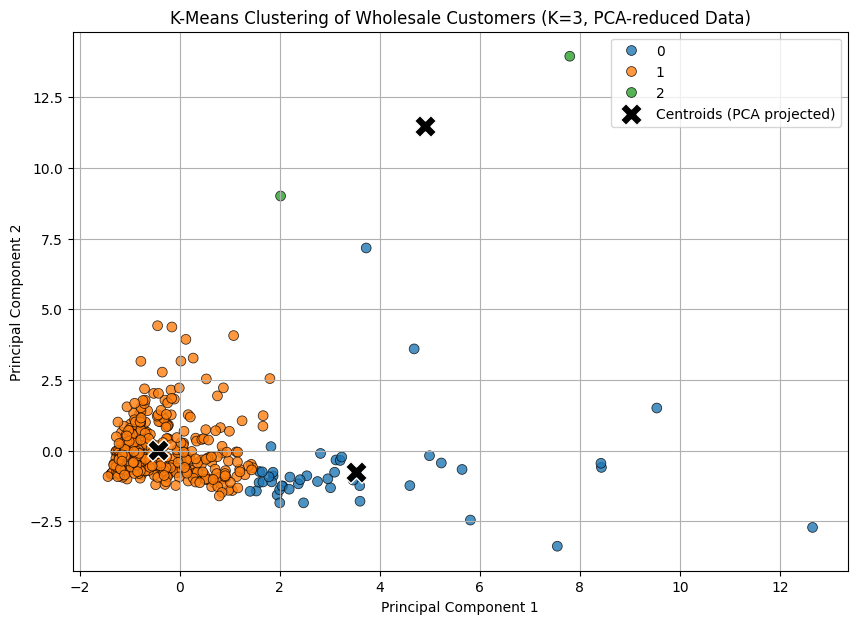

In [21]:
# --- 6. Visualize the Clustering Results (using PCA for 2D projection) ---
print("\n--- Visualizing Clusters using PCA (2D projection) ---")
pca = PCA(n_components=2, random_state=42)
X_wholesale_pca = pca.fit_transform(X_wholesale_scaled)
centroids_ws_pca = pca.transform(centroids_ws_scaled) # Transform scaled centroids to PCA space

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_wholesale_pca[:, 0], y=X_wholesale_pca[:, 1], hue=cluster_labels_ws,
                palette=sns.color_palette("tab10", n_colors=optimal_k_ws),
                s=50, alpha=0.8, legend='full', edgecolor='k')
plt.scatter(centroids_ws_pca[:, 0], centroids_ws_pca[:, 1],
            s=250, marker='X', c='black', edgecolor='white', label='Centroids (PCA projected)')
plt.title(f"K-Means Clustering of Wholesale Customers (K={optimal_k_ws}, PCA-reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Silhouette Score (another way to evaluate clustering quality)
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_wholesale_scaled, cluster_labels_ws)
print(f"\nFor K={optimal_k_ws}, the average silhouette_score is : {silhouette_avg:.4f}")
print("(Silhouette score ranges from -1 to 1. Higher is better. Values near 0 indicate overlapping clusters.)")



For K=3, the average silhouette_score is : 0.5483
(Silhouette score ranges from -1 to 1. Higher is better. Values near 0 indicate overlapping clusters.)


**Discussion for Wholesale Customers Example:**

- Data Preparation: This dataset has features with vastly different scales (e.g., 'Fresh' vs. 'Detergents_Paper'), making StandardScaler essential. Categorical features like 'Channel' and 'Region' were dropped for simplicity, but in a real analysis, they might be handled differently (e.g., one-hot encoding if used with algorithms that can handle it, or analyzed separately).
- Elbow Method: The elbow on real-world data might be less distinct than on synthetic blobs. You might need to combine it with other methods (like Silhouette analysis, shown briefly) or domain knowledge to choose K.
- Cluster Analysis: After clustering, it's important to analyze the characteristics of each cluster. The groupby().mean() helps understand the average spending habits for each customer segment identified by K-Means. This is where the business insights come from.
- Visualization with PCA: Since the data has more than 2 features, we use Principal Component Analysis (PCA) to reduce its dimensionality to 2D for visualization purposes. This gives an approximate view of the cluster separation.
- Silhouette Score: This metric provides a measure of how well-separated the clusters are. A score closer to 1 indicates well-defined clusters.
These two examples illustrate K-Means on both synthetic and a more realistic dataset, covering essential steps like scaling, finding K, fitting the model, and interpreting/visualizing results.